import all dependencies

In [1]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
import os

import dashscope
from dashscope import TextEmbedding
from dashvector import Client, Doc

import json

from sklearn.metrics.pairwise import cosine_similarity
from dashscope import Generation

create a test text database

In [57]:
import os
import fitz

from pysbd import Segmenter

segmenter = Segmenter()

def read_pdfs_to_list(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with fitz.open(file_path) as doc:
                full_text = ""
                for page in doc:
                    full_text += page.get_text()
                
                full_text = re.sub(r"\n", " ", full_text)
                full_text = re.sub(r"\xa0", " ", full_text)
                full_text = re.sub(r"- ", "", full_text)
                pdf_texts.append(segmenter.segment(full_text.lower()))
    return pdf_texts

folder_path = 'D:\\RexZhann\\nlp\\papers'
keyword = 'organic personality'

pdf_texts = read_pdfs_to_list(folder_path)

pdf_texts


[['see discussions, stats, and author profiles for this publication at: https://www.researchgate.net/publication/7419356 diagnostic categories or dimension? ',
  'a question for the diagnostic and statistical manual of mental disorders—fifth edition article  in  journal of abnormal psychology · december 2005 doi: 10.1037/0021-843x.114.4.494 · source: pubmed citations 568 reads 4,708 2 authors, including: douglas b samuel purdue university 66 publications   2,464 citations    see profile all content following this page was uploaded by douglas b samuel on 17 november 2014. ',
  'the user has requested enhancement of the downloaded file. ',
  'diagnostic categories or dimensions? ',
  'a question for the diagnostic and statistical manual of mental disorders—fifth edition thomas ',
  'a. widiger and douglas ',
  'b. samuel university of kentucky the question of whether mental disorders are discrete clinical conditions or arbitrary distinctions along dimensions of functioning is a long-stan

In [58]:
def find_related_sent(keyword, sentences):
    related_sent = []
    for sent_per_text in sentences:
        for i, sent in enumerate(sent_per_text):
            if keyword.lower() in sent.lower():
                for j in range(np.max([0, i - 2]), np.min([i + 2, len(sent_per_text)])):
                    if sent_per_text[j] not in related_sent:
                        related_sent.append(sent_per_text[j])
    return related_sent


articles = find_related_sent(keyword, pdf_texts)
len(articles)

66

In [5]:
articles = articles[30:480]

In [ ]:
articles = ['Depressive disorder (also known as depression) is a common mental disorder. It involves a depressed mood or loss of pleasure or interest in activities for long periods of time.',
            'Depression is different from regular mood changes and feelings about everyday life. It can affect all aspects of life, including relationships with family, friends and community. It can result from or lead to problems at school and at work.',
            'During a depressive episode, a person experiences a depressed mood (feeling sad, irritable, empty). They may feel a loss of pleasure or interest in activities.',
            'Major depression includes symptoms of depressed mood or loss of interest, most of the time for at least 2 weeks, that interfere with daily activities.',
            'Due to the limitations of the above loss functions, we aim to design a loss function that directly optimizes the cosine function for consistency in training and prediction and can be widely used across various datasets.',
            'Though depression and grief share some features, depression is different from grief felt after losing a loved one or sadness felt after a traumatic life event. Depression usually involves self-loathing or a loss of self-esteem, while grief typically does not.',
]


In [6]:
dashscope.api_key='sk-b8ba4c6e0c9b4e7697fd3cdaaebe63f7'

def generate_embeddings(text):
    rsp = TextEmbedding.call(model=TextEmbedding.Models.text_embedding_v2,
                             input=text)
    embeddings = [record['embedding'] for record in rsp.output['embeddings']]
    return embeddings if isinstance(text, list) else embeddings[0]


用qwen大模型api进行的分词

In [ ]:
def tokenizer(articles):
    prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
    # CONTEXT #
    You are an expert at tokenizing text based on the context of the text, including extracting out any possible phrases and chunks of nouns
    # OBJECTIVE #
    tokenize these paragraphs:{articles}
    # STYLE #
    output only the result of tokenization, separated by quotation and space.
    # RESPONSE #
    do not output anything other than the result of tokenization
    '''
    
    rsp = Generation.call(model='qwen-turbo', prompt=prompt)
    return rsp.output.text

In [7]:
from tqdm import tqdm

In [8]:
def tokenizer_batch(articles, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an expert at tokenizing text based on the context of the text, including extracting out any possible phrases and chunks of nouns. You are also
            good at recognizing the logical relation between the phrases in one context.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{batch}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than single nouns, try to output chunks of nouns when possible.
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output complete sentences.
            '''
            
            rsp = Generation.call(model='qwen-turbo', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [ ]:
'''# CONTEXT #
    You are an expert at tokenizing text based on the context of the text, including etracting out any possible phrases and chunks of nouns
    # OBJECTIVE #
    tokenize these paragraphs:['Depressive disorder (also known as depression) is a common mental disorder. It involves a depressed mood or loss of pleasure or interest in activities for long periods of time.',
                'Depression is different from regular mood changes and feelings about everyday life. It can affect all aspects of life, including relationships with family, friends and community. It can result from or lead to problems at school and at work.',
                'During a depressive episode, a person experiences a depressed mood (feeling sad, irritable, empty). They may feel a loss of pleasure or interest in activities.',
                'Major depression includes symptoms of depressed mood or loss of interest, most of the time for at least 2 weeks, that interfere with daily activities.',
                'Due to the limitations of the above loss functions, we aim to design a loss function that directly optimizes the cosine function for consistency in training and prediction and can be widely used across various datasets.',
                'Though depression and grief share some features, depression is different from grief felt after losing a loved one or sadness felt after a traumatic life event. Depression usually involves self-loathing or a loss of self-esteem, while grief typically does not.',
    ]
    # STYLE #
    output only the result of tokenization, separated by quotation and comma, no linebreaks.
    # RESPONSE #
    do not output anything other than the result of tokenization
    '''
    

In [59]:
res = tokenizer_batch(articles)

phrases_llm = [re.findall(r'"(.*?)"', phrase) for phrase in res]



  0%|          | 0/11 [00:00<?, ?it/s]

Debug: Processing batch 1/11 with 6 phrases


 55%|█████▍    | 6/11 [00:03<00:03,  1.59it/s]

Debug: Processing batch 2/11 with 6 phrases


12it [00:06,  2.08it/s]                       

Debug: Processing batch 3/11 with 6 phrases


18it [00:08,  2.05it/s]

Debug: Processing batch 4/11 with 6 phrases


24it [00:10,  2.48it/s]

Debug: Processing batch 5/11 with 6 phrases


30it [00:12,  2.76it/s]

Debug: Processing batch 6/11 with 6 phrases


36it [00:13,  3.31it/s]

Debug: Processing batch 7/11 with 6 phrases


42it [00:17,  2.51it/s]

Debug: Processing batch 8/11 with 6 phrases


48it [00:18,  2.97it/s]

Debug: Processing batch 9/11 with 6 phrases


54it [00:26,  1.51it/s]

Debug: Processing batch 10/11 with 6 phrases


60it [00:56,  1.97s/it]

Debug: Processing batch 11/11 with 6 phrases


66it [01:03,  1.04it/s]


In [60]:
phrases_llm = [[phrase for phrase in phrases if len(phrase) <= 30 and len(phrase) > 4 and '%' not in phrase] for phrases in phrases_llm]
phrases_llm = [phrases for phrases in phrases_llm if len(phrases) != 0]
len(phrases_llm)

11

In [ ]:
phrases_llm

In [ ]:
phrases_llm = re.findall(r'"(.*?)"', tokenizer(articles))
phrases_llm
tokenizer(articles)

用Spacy模型进行的分词（用时0.8但需要根据语言调整依赖关系筛选）

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_phrases(doc):
    phrases = []

    # 提取名词短语
    for chunk in doc.noun_chunks:
        phrases.append(chunk.text)
    
    # 提取动词短语
    for token in doc:
        if token.dep_ in ('ROOT', 'acl', 'advcl', 'relcl'):
            phrases.append(' '.join([child.text for child in token.subtree]))

    # 提取副词短语
    for token in doc:
        if token.pos_ == 'ADV':
            adverb_phrase = [token.text]
            adverb_phrase.extend([child.text for child in token.children])
            phrases.append(' '.join(adverb_phrase))

    # 提取介词短语并拼接修饰的主体
    for token in doc:
        if token.dep_ == 'prep':  # 如果是介词
            prep_phrase = ' '.join([child.text for child in token.subtree])
            head = token.head
            head_phrase = head.text
            if head.dep_ in ('ROOT', 'acl', 'advcl', 'relcl', 'pobj', 'dobj', 'nsubj'):
                head_phrase = ' '.join([child.text for child in head.subtree])
            phrases.append([f"{head_phrase}", 1])
    
    return phrases

# 提取所有文章中的短语
all_phrases = []
for article in articles:
    doc = nlp(article)
    phrases = extract_phrases(doc)
    all_phrases.extend(phrases)


print("phrases extracted:")
for phrase in all_phrases:
    print(phrase)

In [ ]:
docs = [nlp(article) for article in articles]
for token in docs[0]:
    print([token.text, token.dep_])

用BERT模型分词(用时3m56)

In [ ]:
# 加载 DistilBERT 模型和 tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# 提取短语函数
def extract_phrases(article):
    phrases = []
    sentences = article.split('.')
    for sentence in sentences:
        words = sentence.split()
        phrases.extend(words)
    return phrases

# 提取所有文章中的短语
all_phrases = []
for article in articles:
    phrases = extract_phrases(article)
    all_phrases.extend(phrases)

Prepare for embedding and vecotr search

In [11]:
client = Client(
  api_key='sk-0R9jI2212bV7Ma7u7ba4UmX8QQ8Gt2E2060C14D5411EF9A1EB61E393DC850',
  endpoint='vrs-cn-0mm3ulqnq00032.dashvector.cn-hangzhou.aliyuncs.com'
)

collection = client.get('sample1')
assert collection

In [ ]:
phrases_llm[0]

In [ ]:
for phrase in phrases_llm:
    # 批量 embedding

    embedding = generate_embeddings(phrase)


    
    rsp = collection.insert(
        
        Doc(id=str(len(phrase)), vector=embedding, fields={"title": phrase}) 
           
    )
    assert rsp

In [63]:
def batch_generator(items, batchsize):
    for i in range(0, len(items), batchsize):
        yield items[i:i + batchsize]

def process_phrases(phrases_llm, batchsize=6):
    for batch in batch_generator(phrases_llm, batchsize):
        
        for sent in batch:
            embeddings = [generate_embeddings(phrase) for phrase in sent]

            
            docs = [Doc(id=str(len(phrase)), vector=embedding, fields={"title": phrase}) 
                    for phrase, embedding in zip(sent, embeddings)]
        
        rsp = collection.insert(docs)
        assert rsp
process_phrases(phrases_llm, batchsize=5)


ReadTimeout: HTTPSConnectionPool(host='dashscope.aliyuncs.com', port=443): Read timed out. (read timeout=300)

这里用测试的输入词‘{}’尝试输出

In [42]:
rsp = collection.query(generate_embeddings(keyword), output_fields=['title'],topk=20)


related_phrases = [doc.fields['title'] for doc in rsp.output]
related_phrases_embeddings = [doc.vector for doc in rsp.output]


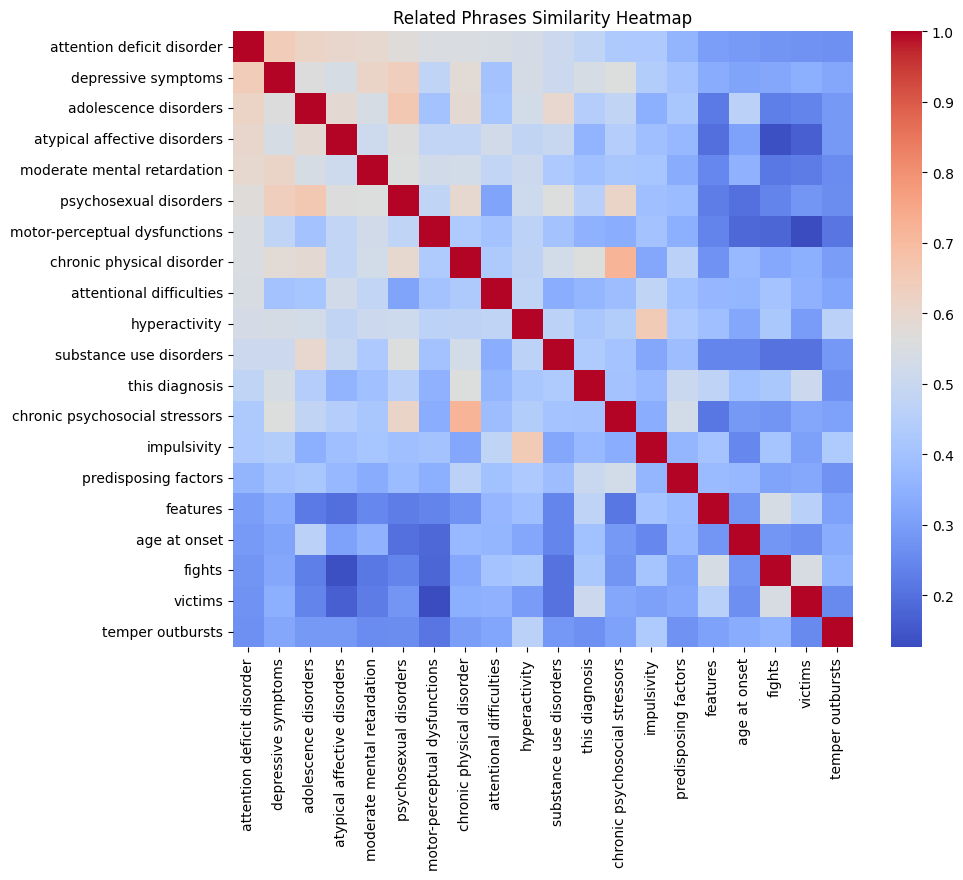

In [43]:
related_phrases_embeddings = [generate_embeddings(phrase) for phrase in related_phrases]

similarity_matrix = cosine_similarity(related_phrases_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=related_phrases, yticklabels=related_phrases, cmap='coolwarm')
plt.title('Related Phrases Similarity Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

可以继续优化删除掉与原词相似度太高的词（相似度太高说明是近义词，与我们需要的逻辑关系不符），但是感觉也并没有实现筛选出固定语义的目的

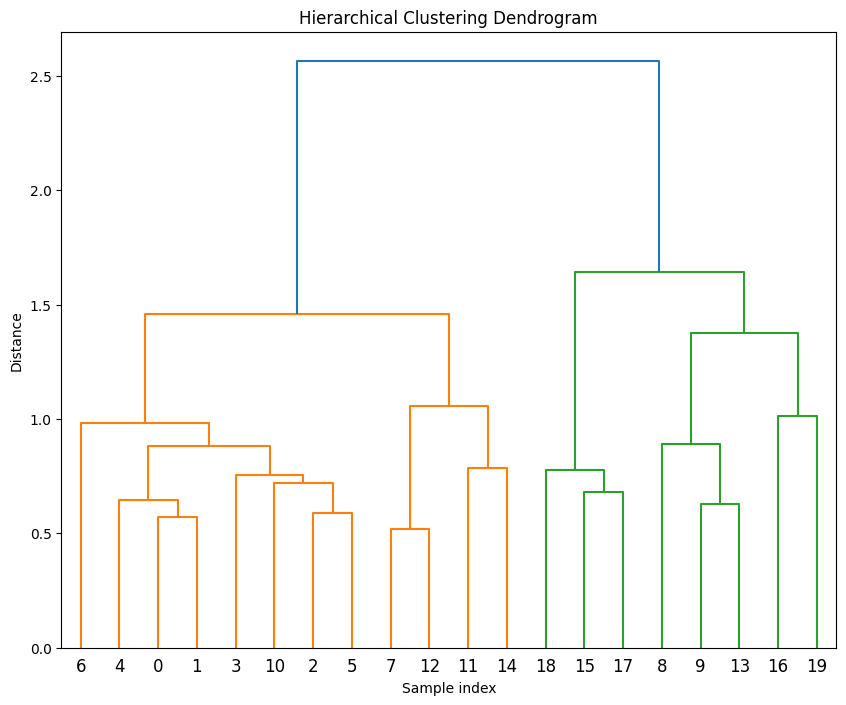

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 层次聚类
Z = linkage(similarity_matrix, 'ward')

# 绘制层次聚类树状图
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [47]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# 使用相似度矩阵进行层次聚类
Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

# 将短语分为k类
k = 5  # 假设我们要分为5类
clusters = fcluster(Z, k, criterion='maxclust')

def get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings):
    rep_phrases = []
    rep_phrase_emb = []
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        cluster_similarity = similarity_matrix[cluster_indices][:, cluster_indices]
        centroid_index = np.argmax(np.sum(cluster_similarity, axis=0))
        rep_index = cluster_indices[centroid_index]
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
    return rep_phrases, rep_phrase_emb

# 获取代表性短语
final_phrases, final_emb = get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings)
print(f"Final {k} characteristics of {keyword}:")


for phrase in final_phrases:
    print(phrase)


Final 5 characteristics of attention deficit disorder:
attention deficit disorder
chronic physical disorder
fights
hyperactivity
temper outbursts


In [46]:
def get_representative_phrases( clusters, k, related_phrases, related_phrases_embeddings, target_emb):
    rep_phrases = []
    rep_phrase_emb = []
    
    # 计算target_emb与所有短语嵌入的相似度
    target_similarity = np.dot(related_phrases_embeddings, target_emb)
    
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        
        # 如果当前聚类中没有元素，则跳过
        if not cluster_indices:
            continue
        
        # 计算target_emb与当前聚类中所有短语的相似度
        cluster_similarities = target_similarity[cluster_indices]
        
        # 找出与target_emb最相似的短语索引
        max_similarity_index = np.argmax(cluster_similarities)
        rep_index = cluster_indices[max_similarity_index]
        
        # 添加代表性短语和其嵌入向量
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
        
    return rep_phrases, rep_phrase_emb

final_phrases, final_emb = get_representative_phrases(clusters, k, related_phrases, related_phrases_embeddings, generate_embeddings(keyword))
print(f"Final {k} characteristics of {keyword}:")
for phrase in final_phrases:
    print(phrase)

Final 5 characteristics of attention deficit disorder:
attention deficit disorder
chronic physical disorder
features
attentional difficulties
age at onset


计算输出的负相关性，负相关性是衡量输出重复度的重要指标

In [48]:
def average_dot_product(vectors):
    n = len(vectors)
    dot_products = []

    for i in range(n):
        for j in range(i + 1, n):
            dot_product = np.dot(vectors[i], vectors[j])
            dot_products.append(dot_product)
    
    average_dot = np.mean(dot_products)
    return average_dot

ave_dot = average_dot_product(final_emb)
ave_cos = np.mean(cosine_similarity(final_emb))

print(f'average dot product is {ave_dot}')
print(f'average cosine similarity is {ave_cos}')

average dot product is 0.39699247377830693
average cosine similarity is 0.5175939790226458


这里用大模型尝试恢复到原本的输入词‘symptoms of depression'

In [23]:
def retrieve(articles, final_phrases):
    prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
    # CONTEXT #
    You are an expert at retrieving a phrase from a text database given a list of the characteristics of that phrase.
    # OBJECTIVE #
    Pick exactly one phrase or word from the text database that best fits the list of characteristics.

    list of characteristics: {final_phrases}

    text database: {articles}

    # STYLE #
    output only the result of phrase retrieval. 
    The result could be a single word or a short phrase, but never a sentence. 
    The result must be from the text database.
    Set the temperature parameter to 0 to ensure a precise output
    # RESPONSE #
    do not output anything other than the result of retrieval
    '''
    
    rsp = Generation.call(model='qwen-max', prompt=prompt)
    return rsp.output.text

In [24]:
def retriever_batch(articles, final_phrases, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an expert at retrieving a phrase from a text database given a list of the characteristics of that phrase.
            # OBJECTIVE #
            Pick exactly one phrase or word from the text database that best fits the list of characteristics.

            list of characteristics: {final_phrases}

            text database: {batch}

            # STYLE #
            output only the result of phrase retrieval. 
            The result could be a single word or a short phrase, but never a sentence. 
            The result must be from the text database.
            Set the temperature parameter to 0 to ensure a precise output
            # RESPONSE #
            do not output anything other than the result of retrieval
            '''
            
            rsp = Generation.call(model='qwen-turbo', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  # 更新进度条
    
    return tokenized_results

In [49]:
retrieval = retriever_batch(articles, final_phrases)

  0%|          | 0/25 [00:00<?, ?it/s]

Debug: Processing batch 1/25 with 6 phrases


 24%|██▍       | 6/25 [00:00<00:01, 12.01it/s]

Debug: Processing batch 2/25 with 6 phrases


 48%|████▊     | 12/25 [00:00<00:00, 13.55it/s]

Debug: Processing batch 3/25 with 6 phrases


 72%|███████▏  | 18/25 [00:01<00:00, 13.64it/s]

Debug: Processing batch 4/25 with 6 phrases


 96%|█████████▌| 24/25 [00:01<00:00, 14.15it/s]

Debug: Processing batch 5/25 with 6 phrases


30it [00:02, 14.37it/s]                        

Debug: Processing batch 6/25 with 6 phrases


36it [00:02, 14.88it/s]

Debug: Processing batch 7/25 with 6 phrases


42it [00:02, 14.99it/s]

Debug: Processing batch 8/25 with 6 phrases


48it [00:03, 15.07it/s]

Debug: Processing batch 9/25 with 6 phrases


54it [00:03, 15.47it/s]

Debug: Processing batch 10/25 with 6 phrases


60it [00:04, 15.55it/s]

Debug: Processing batch 11/25 with 6 phrases


66it [00:04, 15.25it/s]

Debug: Processing batch 12/25 with 6 phrases


72it [00:04, 15.52it/s]

Debug: Processing batch 13/25 with 6 phrases


78it [00:05, 15.91it/s]

Debug: Processing batch 14/25 with 6 phrases


84it [00:05, 15.78it/s]

Debug: Processing batch 15/25 with 6 phrases


90it [00:06, 15.17it/s]

Debug: Processing batch 16/25 with 6 phrases


96it [00:06, 14.72it/s]

Debug: Processing batch 17/25 with 6 phrases


102it [00:07, 10.64it/s]

Debug: Processing batch 18/25 with 6 phrases


108it [00:07, 11.91it/s]

Debug: Processing batch 19/25 with 6 phrases


114it [00:08,  8.78it/s]

Debug: Processing batch 20/25 with 6 phrases


120it [00:09,  9.37it/s]

Debug: Processing batch 21/25 with 6 phrases


126it [00:09, 10.66it/s]

Debug: Processing batch 22/25 with 6 phrases


132it [00:10, 11.57it/s]

Debug: Processing batch 23/25 with 6 phrases


138it [00:10, 12.32it/s]

Debug: Processing batch 24/25 with 6 phrases


144it [00:10, 13.06it/s]

Debug: Processing batch 25/25 with 2 phrases


146it [00:11, 12.78it/s]


In [50]:
len(retrieval)
ave_emb_1 = np.array([generate_embeddings(phrase) for phrase in retrieval])


In [51]:
retrieval_1 = [doc.fields['title'] for doc in collection.query(np.mean(ave_emb_1, axis=0), output_fields=['title'],topk=1).output]
print(f'the retrieval result from the LLMs is : {retrieval_1[0]}')

the retrieval result from the LLMs is : attention deficit disorder


In [52]:
cos_score = cosine_similarity([generate_embeddings(keyword)], [generate_embeddings(retrieval_1[0])])
print(cos_score)

[[1.]]


或者对输出list取均值重新请求embeddings

In [53]:


retrieval_2 = [doc.fields['title'] for doc in collection.query(np.mean(np.array(final_emb), axis=0), output_fields=['title'],topk=1).output]
retrieval_2

['hyperactivity']

In [54]:
np.array(final_emb).shape


(5, 1536)

In [56]:
cos_score = cosine_similarity([generate_embeddings(keyword)], [generate_embeddings(retrieval_2[0])])
print(cos_score)

[[0.53304137]]
